# Modeling and Forecasting
In this file, the following processes will be performed to model and forecast the time-series data:
- Plot the ACF and PACF charts and find the optimal parameters (P,Q)
- Model and fit AR, MA, ARMA, ARIMA, and SARIMAX to the train data
- Choose model based on AIC metric
- forecast the last 12 months of data and use mean squared error to evaluate model

## Importing libraries and perform same data transformations from data_exploration.ipynb and stationarization_decomposition.ipynb
___

In [44]:
# Import basic libraries
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
%matplotlib inline  
%timeit

In [45]:
# Import data as pandas dataframe
df = pd.read_excel("MER_T12_06.xlsx")

In [46]:
# to ignore warnings
import warnings
import itertools

warnings.filterwarnings("ignore")

In [47]:
# from datetime import datetime
# conversion of "YYYYMM" columnn into standard datetime format
# reformat date from YYYYMM to YYYY-MM for ease of interpretation
# We are using errors=’coerce’. It will replace all non-numeric values with NaN.
# Remove all "NaT" values from Date

dateparse = lambda x: pd.to_datetime(x, format='%Y%m', errors = 'coerce')
df = pd.read_excel('MER_T12_06.xlsx', parse_dates=['YYYYMM'], index_col='YYYYMM', date_parser=dateparse) 

In [48]:
# filter out all "Nat" values from date index
ts = df[pd.Series(pd.to_datetime(df.index, errors='coerce')).isna().values]
df = df.drop(ts.index)

In [49]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4707 entries, 1973-01-01 to 2016-07-01
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   MSN          4707 non-null   object
 1   Value        4707 non-null   object
 2   Description  4707 non-null   object
dtypes: object(3)
memory usage: 147.1+ KB


In [50]:
# Make "Values" column into d-type float and turn errors into 'nan'
df["Value"] = pd.to_numeric(df["Value"], errors="coerce")
# Change 'YYYYMM' to 'Date'
df.index.names = ['Date']

In [51]:
# Set 'Date' as index and create an index column
# df = df.reset_index().set_index("Date").to_period('M')

In [52]:
# Rename the unique variables to a shortened version
mapping = {
    "Coal Electric Power Sector CO2 Emissions": "Coal",
    "Natural Gas Electric Power Sector CO2 Emissions": "Natural Gas",
    "Distillate Fuel, Including Kerosene-Type Jet Fuel, Oil Electric Power Sector CO2 Emissions": "Distillate Fuel",
    "Petroleum Coke Electric Power Sector CO2 Emissions": "Petroleum Coke",
    "Residual Fuel Oil Electric Power Sector CO2 Emissions": "Residual Fuel Oil",
    "Petroleum Electric Power Sector CO2 Emissions": "Petroleum",
    "Geothermal Energy Electric Power Sector CO2 Emissions": "Geothermal",
    "Non-Biomass Waste Electric Power Sector CO2 Emissions": "Non-Biomass Waste",
    "Total Energy Electric Power Sector CO2 Emissions": "Total Energy",
}

df["Description"] = df["Description"].map(mapping)

In [53]:
# Turn categorical variables in "Description" into separate rows.
df = pd.pivot_table(df, index='Date', columns='Description', values='Value')

In [54]:
# Create columns for year and month
df["Year"] = df.index.year
df["Month"] = df.index.month

In [55]:
# Checking to see if dataframe tranformations were successful
df.head()

Description,Coal,Distillate Fuel,Geothermal,Natural Gas,Non-Biomass Waste,Petroleum,Petroleum Coke,Residual Fuel Oil,Total Energy,Year,Month
Date,,,,,,,,,,,
1973-01-01,72.076,2.375,NaN,12.175,NaN,27.369,0.128,24.867,111.621,1973,1
1973-02-01,64.442,2.061,NaN,11.708,NaN,23.034,0.106,20.867,99.185,1973,2
1973-03-01,64.084,1.171,NaN,13.994,NaN,21.034,0.083,19.780,99.112,1973,3
1973-04-01,60.842,1.022,NaN,14.627,NaN,17.714,0.130,16.562,93.183,1973,4
1973-05-01,61.798,0.949,NaN,17.344,NaN,18.870,0.167,17.754,98.012,1973,5


## Creating new dataframe for Natural gas
___

In [56]:
###Slice the data to get the monthly total CO2 emissions of only Natural Gas Electric Power Sector
df_NG = pd.DataFrame()
df_NG["Natural Gas"] = df["Natural Gas"]

Here we'll perform the train-test split. The split will be done by making the test set the last two years of the data (2014-2016)

In [57]:
test_size = 24

df_train = df_NG[:-test_size]
df_test = df_NG[-test_size:]

## Transformation of the dataset into a stationary one
___
We can use some of the following methods to convert a non-stationary series into a stationary one:
1. Log Transformation
2. Log + Differencing the series (lagged series)

In [58]:
#Import the required package

import statsmodels
import statsmodels.api as sm
from statsmodels.tsa.stattools import coint, adfuller

In [59]:
# Calculate the rolling mean and standard deviation for a window of 12 observations
rolmean=df_train.rolling(window=12).mean()
rolstd=df_train.rolling(window=12).std()

**1. Log Transformation**

In [60]:
#Perform transformations from stationarization_decomposition.ipynb
df_log = np.log(df_train)
MAvg = df_log.rolling(window=12).mean()
MStd = df_log.rolling(window=12).std()

**2. Log + Differencing Series**

In [61]:
#Perform transformations from stationarization_decomposition.ipynb
df_shift = df_log - df_log.shift(periods = 1)
MAvg_shift = df_shift.rolling(window=12).mean()
MStd_shift = df_shift.rolling(window=12).std()

#Dropping the null values that we get after applying differencing method
df_shift = df_shift.dropna()

## Find optimal parameters (P, Q) and build the AR, MA, ARMA, ARIMA, & SARIMAX models
___
From the decomposition, seasonality is present in the data, so models that take seasonality into account should perform best. Assuming we did not notice this, let's use all models and compare.

<Figure size 1152x576 with 0 Axes>

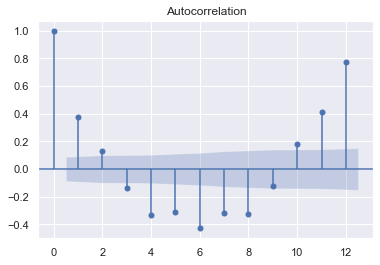

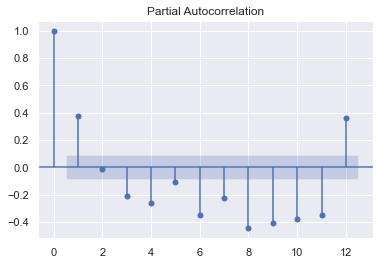

In [62]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

plt.figure(figsize = (16,8))
plot_acf(df_shift, lags = 12) 
plt.show() 
plot_pacf(df_shift, lags = 12) 
plt.show()

### Observations
- The purpose of modeling using AR and MA despite observed seasonality is to compare all models at the  end.
- The highest lag in the PACF plot that extends beyond the significant boundary is lag 1, so p=1 for forecasting AR models
- The value the ACF crosses the upper confidence interval for the first time is after lag 2. So q=2

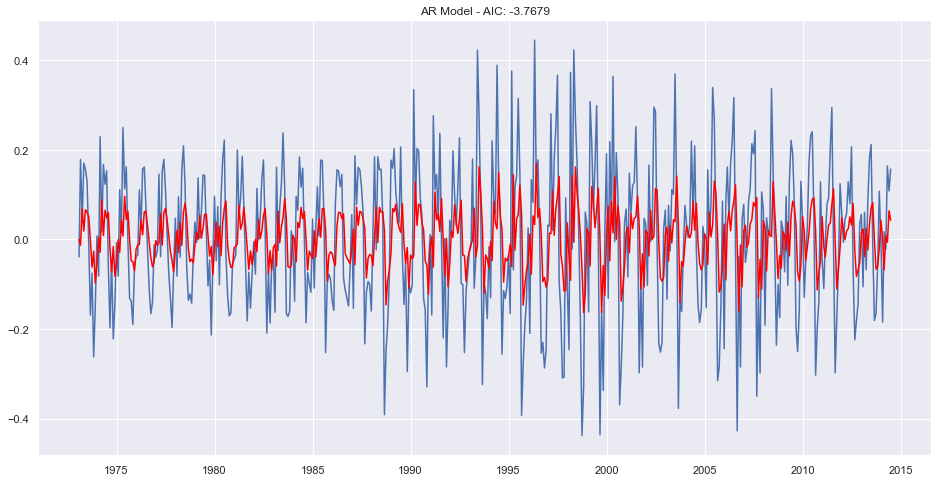

In [63]:
#Importing AutoReg function to apply AR model
from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import mean_squared_error

#Code here
plt.figure(figsize=(16,8))
model_AR = AutoReg(df_shift, lags=1) #Using number of lags as 1
results_AR = model_AR.fit()
plt.plot(df_shift)
predict = results_AR.predict(start=0,end=len(df_shift)-1)
predict = predict.fillna(0) #Converting NaN values to 0
plt.plot(predict, color='red')
plt.title('AR Model - AIC: %.4f'% results_AR.aic)  #Calculating rmse
plt.show()

### Observations
- The AIC value was found to be -3.7679, let's continue the analysis to compare how other models did.

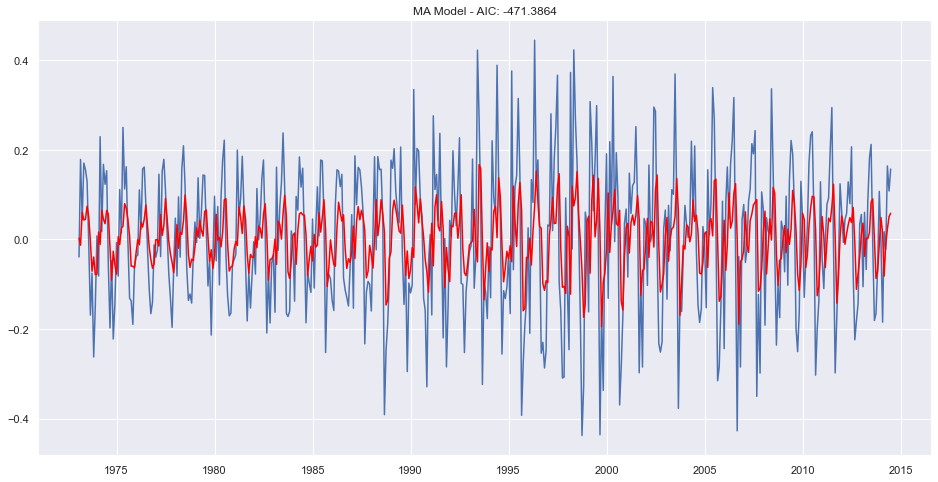

In [64]:
from statsmodels.tsa.arima.model import ARIMA

#Code here
plt.figure(figsize=(16,8))
model_MA = ARIMA(df_shift, order=(0, 0, 2)) #Using p=0, d=0, q=2
results_MA = model_MA.fit()
plt.plot(df_shift)
plt.plot(results_MA.fittedvalues, color='red')
plt.title('MA Model - AIC: %.4f'% results_MA.aic)
plt.show()

### Observations
- The AIC is found to be -471.3864, which shows a large improvement over the AR model.

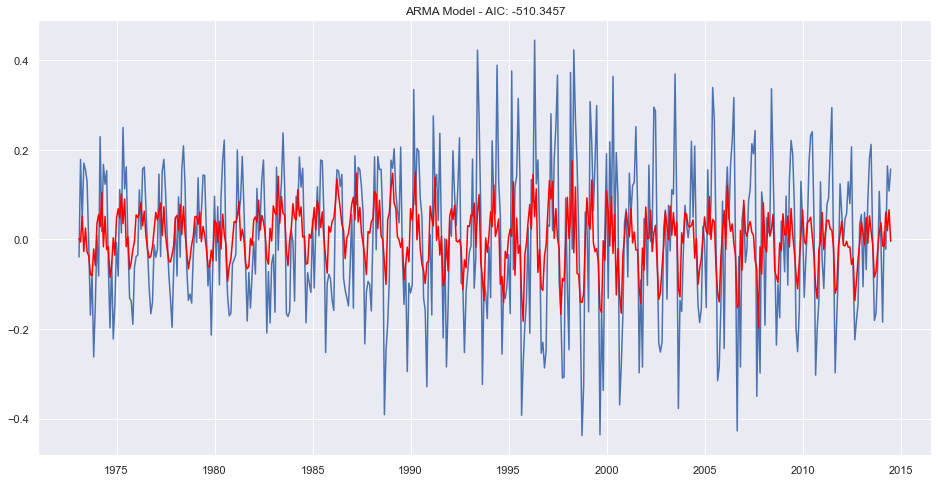

In [65]:
#Code here
plt.figure(figsize=(16,8))
model_ARMA = ARIMA(df_shift, order=(1, 0, 2)) #Using p=1, d=0, q=2
results_ARMA = model_ARMA.fit()
plt.plot(df_shift)
plt.plot(results_ARMA.fittedvalues, color='red')
plt.title('ARMA Model - AIC: %.4f'% results_ARMA.aic)
plt.show()

### Observations
- The AIC was found to be -510.3457, which is better than both AR And MA.

The AIC value of the ARMA model is the lowest values, which implies that it is the models that fits the training data the best.

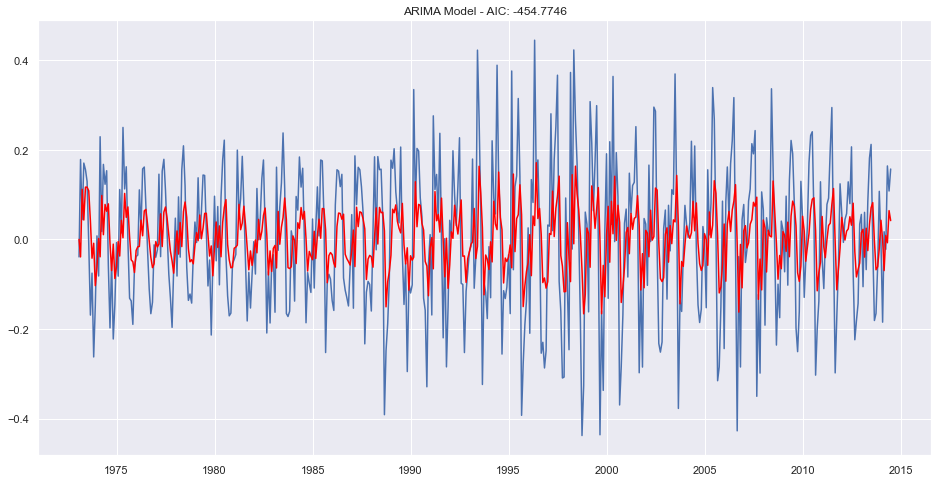

In [66]:
from statsmodels.tsa.arima.model import ARIMA

#Code here
plt.figure(figsize=(16,8))
model_ARIMA = ARIMA(df_shift, order=(1,1,2)) #Using p=1, d=1, q=2
results_ARIMA = model_ARIMA.fit()
plt.plot(df_shift)
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('ARIMA Model - AIC: %.4f'% results_ARIMA.aic)
plt.show()

### Observations
- The RMSE and AIC were found to be 0.1516 and -454.77, respectively. So, the ARMA outperformed the ARIMA model.
- At our current progress, the ARMA model fit the train set the best compared to AR, MA, and ARIMA

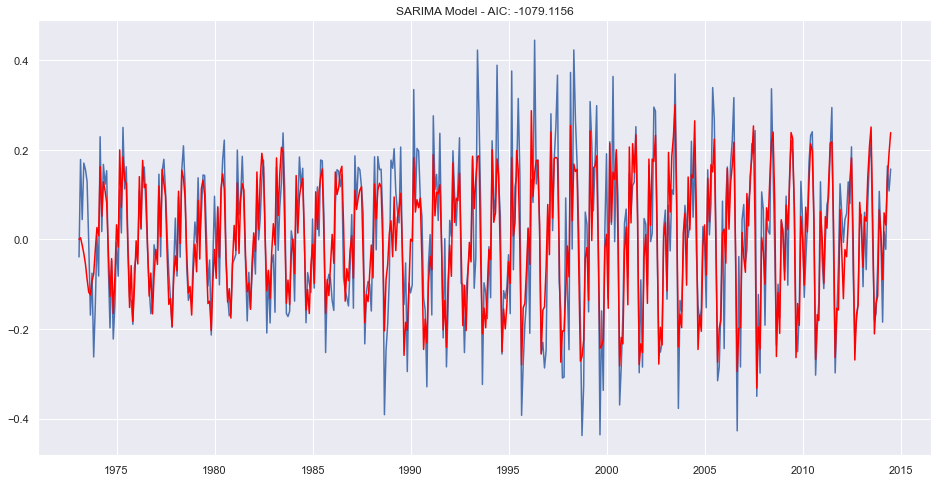

In [67]:
# Create a SARIMA Model to fit to Natural Gas
from statsmodels.tsa.statespace.sarimax import SARIMAX
model_SARIMA = SARIMAX(df_shift, order=(1,0,2), seasonal_order=(1,0,2,12))
results_SARIMA = model_SARIMA.fit()
predictions_SARIMA = results_SARIMA.predict()

#Plotting the original vs predicted series
plt.figure(figsize=(16,8))
plt.plot(df_shift)
plt.plot(results_SARIMA.fittedvalues, color='red')
plt.title('SARIMA Model - AIC: %.4f'% results_SARIMA.aic)
plt.show()

#mean_squared_error(results_SARIMA.fittedvalues,df_shift['Natural Gas']

###  Observations
- The SARIMAX Model fit the best of all models due to an incorporation of a seasonality parameter
- The hyperparameters were chosen using the parameters from the ARMA model and some manually tuning to decrease the AIC and RMSE

Ahtough the most suitable model was found, the hyperparameters can be improved. To do this, a Grid Search will be used. The following code below is not my own and all credit goes to Jessica Forrest-Baldini (https://towardsdatascience.com/grid-search-for-sarimax-parameters-adbd5104cb8b).

In [68]:
### Import Packages ###

import itertools
# import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX

### Define Parameter Ranges to Test ###

# Note: higher numbers will result in code taking much longer to run
# Here we have it set to test p,d,q each = 0, 1 & 2

# Define the p, d and q parameters to take any value between 0 and 3
p = d = q = range(0, 3)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
# Note: here we have 12 in the 's' position as we have monthly data
# You'll want to change this according to your time series' frequency
pdqs = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

### Run Grid Search ###

# Note: this code will take a while to run

# Define function
def sarimax_gridsearch(ts, pdq, pdqs, maxiter=30):
    '''
    Input: 
        ts : your time series data
        pdq : ARIMA combinations from above
        pdqs : seasonal ARIMA combinations from above
        maxiter : number of iterations, increase if your model isn't converging
        frequency : default='M' for month. Change to suit your time series frequency
            e.g. 'D' for day, 'H' for hour, 'Y' for year. 
        
    Return:
        Prints out top 5 parameter combinations
        Returns dataframe of parameter combinations ranked by BIC
    '''

    # Run a grid search with pdq and seasonal pdq parameters and get the best BIC value
    ans = []
    for comb in pdq:
        for combs in pdqs:
            try:
                mod = SARIMAX(ts, # this is your time series you will input
                                                order=comb,
                                                seasonal_order=combs)
#                                                 enforce_stationarity=False,
#                                                 enforce_invertibility=False,
#                                                 freq=freq)

                output = mod.fit(maxiter=maxiter) 
                ans.append([comb, combs, output.aic])
                print('SARIMAX {} x {}12 : AIC Calculated ={}'.format(comb, combs, output.aic))
            except:
                continue
            
    # Find the parameters with minimal BIC value

    # Convert into dataframe
    ans_df = pd.DataFrame(ans, columns=['pdq', 'pdqs', 'aic'])

    # Sort and return top 5 combinations
    ans_df = ans_df.sort_values(by=['aic'],ascending=True)[0:5]
    
    return ans_df
    
### Apply function to your time series data ###

# Remember to change frequency to match your time series data
sarimax_gridsearch(df_shift, pdq, pdqs)

SARIMAX (0, 0, 0) x (0, 0, 0, 12)12 : AIC Calculated =-391.2259754925322
SARIMAX (0, 0, 0) x (0, 0, 1, 12)12 : AIC Calculated =-611.0410047231928
SARIMAX (0, 0, 0) x (0, 0, 2, 12)12 : AIC Calculated =-732.6005307431975
SARIMAX (0, 0, 0) x (0, 1, 0, 12)12 : AIC Calculated =-793.2272844846852
SARIMAX (0, 0, 0) x (0, 1, 1, 12)12 : AIC Calculated =-1011.8864755718298
SARIMAX (0, 0, 0) x (0, 1, 2, 12)12 : AIC Calculated =-1010.1142880774418
SARIMAX (0, 0, 0) x (0, 2, 0, 12)12 : AIC Calculated =-245.77305229269484
SARIMAX (0, 0, 0) x (0, 2, 1, 12)12 : AIC Calculated =-715.6706574038574
SARIMAX (0, 0, 0) x (0, 2, 2, 12)12 : AIC Calculated =-900.7032981769722
SARIMAX (0, 0, 0) x (1, 0, 0, 12)12 : AIC Calculated =-859.7366797493232
SARIMAX (0, 0, 0) x (1, 0, 1, 12)12 : AIC Calculated =-1026.3439101398294
SARIMAX (0, 0, 0) x (1, 0, 2, 12)12 : AIC Calculated =-1024.437541491559
SARIMAX (0, 0, 0) x (1, 1, 0, 12)12 : AIC Calculated =-923.3010236188535
SARIMAX (0, 0, 0) x (1, 1, 1, 12)12 : AIC Calcu

SARIMAX (0, 1, 1) x (0, 1, 1, 12)12 : AIC Calculated =-997.5171327813478
SARIMAX (0, 1, 1) x (0, 1, 2, 12)12 : AIC Calculated =-995.8704753269528
SARIMAX (0, 1, 1) x (0, 2, 0, 12)12 : AIC Calculated =-236.09068748971129
SARIMAX (0, 1, 1) x (0, 2, 1, 12)12 : AIC Calculated =-699.8762789142093
SARIMAX (0, 1, 1) x (0, 2, 2, 12)12 : AIC Calculated =-882.2007597054322
SARIMAX (0, 1, 1) x (1, 0, 0, 12)12 : AIC Calculated =-851.659261106586
SARIMAX (0, 1, 1) x (1, 0, 1, 12)12 : AIC Calculated =-1016.520300664175
SARIMAX (0, 1, 1) x (1, 0, 2, 12)12 : AIC Calculated =-1016.4318472704306
SARIMAX (0, 1, 1) x (1, 1, 0, 12)12 : AIC Calculated =-911.4025715852804
SARIMAX (0, 1, 1) x (1, 1, 1, 12)12 : AIC Calculated =-993.9838729510382
SARIMAX (0, 1, 1) x (1, 1, 2, 12)12 : AIC Calculated =-993.5756877876065
SARIMAX (0, 1, 1) x (1, 2, 0, 12)12 : AIC Calculated =-515.4653049685096
SARIMAX (0, 1, 1) x (1, 2, 1, 12)12 : AIC Calculated =-816.9575913221514
SARIMAX (0, 1, 1) x (1, 2, 2, 12)12 : AIC Calculat

SARIMAX (0, 2, 2) x (1, 0, 0, 12)12 : AIC Calculated =-719.3576395767423
SARIMAX (0, 2, 2) x (1, 0, 1, 12)12 : AIC Calculated =-955.1537458612987
SARIMAX (0, 2, 2) x (1, 0, 2, 12)12 : AIC Calculated =-892.9988649079926
SARIMAX (0, 2, 2) x (1, 1, 0, 12)12 : AIC Calculated =-892.0470453066351
SARIMAX (0, 2, 2) x (1, 1, 1, 12)12 : AIC Calculated =-950.8958244559947
SARIMAX (0, 2, 2) x (1, 1, 2, 12)12 : AIC Calculated =-921.8055791509489
SARIMAX (0, 2, 2) x (1, 2, 0, 12)12 : AIC Calculated =-430.1031858861707
SARIMAX (0, 2, 2) x (1, 2, 1, 12)12 : AIC Calculated =-798.8252444689392
SARIMAX (0, 2, 2) x (1, 2, 2, 12)12 : AIC Calculated =-692.9094522282633
SARIMAX (0, 2, 2) x (2, 0, 0, 12)12 : AIC Calculated =-914.1692044740595
SARIMAX (0, 2, 2) x (2, 0, 1, 12)12 : AIC Calculated =-972.1969155778668
SARIMAX (0, 2, 2) x (2, 0, 2, 12)12 : AIC Calculated =-890.3977460746248
SARIMAX (0, 2, 2) x (2, 1, 0, 12)12 : AIC Calculated =-926.684375366943
SARIMAX (0, 2, 2) x (2, 1, 1, 12)12 : AIC Calculated

SARIMAX (1, 1, 0) x (1, 1, 1, 12)12 : AIC Calculated =-747.7925818589918
SARIMAX (1, 1, 0) x (1, 1, 2, 12)12 : AIC Calculated =-746.0261924009242
SARIMAX (1, 1, 0) x (1, 2, 0, 12)12 : AIC Calculated =-236.48642253094943
SARIMAX (1, 1, 0) x (1, 2, 1, 12)12 : AIC Calculated =-554.7331862801667
SARIMAX (1, 1, 0) x (1, 2, 2, 12)12 : AIC Calculated =-640.6424400229795
SARIMAX (1, 1, 0) x (2, 0, 0, 12)12 : AIC Calculated =-680.6138640888921
SARIMAX (1, 1, 0) x (2, 0, 1, 12)12 : AIC Calculated =-751.8051124016843
SARIMAX (1, 1, 0) x (2, 0, 2, 12)12 : AIC Calculated =-759.5341920122953
SARIMAX (1, 1, 0) x (2, 1, 0, 12)12 : AIC Calculated =-682.2288962668564
SARIMAX (1, 1, 0) x (2, 1, 1, 12)12 : AIC Calculated =-745.8996895312193
SARIMAX (1, 1, 0) x (2, 1, 2, 12)12 : AIC Calculated =-744.1368321919971
SARIMAX (1, 1, 0) x (2, 2, 0, 12)12 : AIC Calculated =-351.20344460030765
SARIMAX (1, 1, 0) x (2, 2, 1, 12)12 : AIC Calculated =-592.4692768880227
SARIMAX (1, 1, 0) x (2, 2, 2, 12)12 : AIC Calcula

SARIMAX (1, 2, 1) x (2, 0, 0, 12)12 : AIC Calculated =-670.1399440035707
SARIMAX (1, 2, 1) x (2, 0, 1, 12)12 : AIC Calculated =-751.8578752291814
SARIMAX (1, 2, 1) x (2, 0, 2, 12)12 : AIC Calculated =-747.1529925841473
SARIMAX (1, 2, 1) x (2, 1, 0, 12)12 : AIC Calculated =-669.4367891805175
SARIMAX (1, 2, 1) x (2, 1, 1, 12)12 : AIC Calculated =-730.6118791952106
SARIMAX (1, 2, 1) x (2, 1, 2, 12)12 : AIC Calculated =-728.880725152781
SARIMAX (1, 2, 1) x (2, 2, 0, 12)12 : AIC Calculated =-338.7009644469076
SARIMAX (1, 2, 1) x (2, 2, 1, 12)12 : AIC Calculated =-574.6922823794728
SARIMAX (1, 2, 1) x (2, 2, 2, 12)12 : AIC Calculated =-553.8361340884373
SARIMAX (1, 2, 2) x (0, 0, 0, 12)12 : AIC Calculated =-274.1222679179307
SARIMAX (1, 2, 2) x (0, 0, 1, 12)12 : AIC Calculated =-463.8958824271067
SARIMAX (1, 2, 2) x (0, 0, 2, 12)12 : AIC Calculated =-449.2200007777892
SARIMAX (1, 2, 2) x (0, 1, 0, 12)12 : AIC Calculated =-775.0814240715601
SARIMAX (1, 2, 2) x (0, 1, 1, 12)12 : AIC Calculated

SARIMAX (2, 0, 2) x (2, 1, 1, 12)12 : AIC Calculated =-1062.4219268923805
SARIMAX (2, 0, 2) x (2, 1, 2, 12)12 : AIC Calculated =-1061.4028405248328
SARIMAX (2, 0, 2) x (2, 2, 0, 12)12 : AIC Calculated =-711.0605788781113
SARIMAX (2, 0, 2) x (2, 2, 1, 12)12 : AIC Calculated =-921.5356277329273
SARIMAX (2, 0, 2) x (2, 2, 2, 12)12 : AIC Calculated =-908.9822915952448
SARIMAX (2, 1, 0) x (0, 0, 0, 12)12 : AIC Calculated =-328.44032775865634
SARIMAX (2, 1, 0) x (0, 0, 1, 12)12 : AIC Calculated =-486.0758965109491
SARIMAX (2, 1, 0) x (0, 0, 2, 12)12 : AIC Calculated =-589.7462903993672
SARIMAX (2, 1, 0) x (0, 1, 0, 12)12 : AIC Calculated =-625.3435604299489
SARIMAX (2, 1, 0) x (0, 1, 1, 12)12 : AIC Calculated =-838.2108152017092
SARIMAX (2, 1, 0) x (0, 1, 2, 12)12 : AIC Calculated =-836.2253470200945
SARIMAX (2, 1, 0) x (0, 2, 0, 12)12 : AIC Calculated =-78.70460196909654
SARIMAX (2, 1, 0) x (0, 2, 1, 12)12 : AIC Calculated =-551.895775913853
SARIMAX (2, 1, 0) x (0, 2, 2, 12)12 : AIC Calcula

SARIMAX (2, 2, 1) x (0, 0, 0, 12)12 : AIC Calculated =-317.808771339686
SARIMAX (2, 2, 1) x (0, 0, 1, 12)12 : AIC Calculated =-475.58284653049975
SARIMAX (2, 2, 1) x (0, 0, 2, 12)12 : AIC Calculated =-579.2355705850104
SARIMAX (2, 2, 1) x (0, 1, 0, 12)12 : AIC Calculated =-613.2092706183078
SARIMAX (2, 2, 1) x (0, 1, 1, 12)12 : AIC Calculated =-822.7009128015548
SARIMAX (2, 2, 1) x (0, 1, 2, 12)12 : AIC Calculated =-820.8837912042289
SARIMAX (2, 2, 1) x (0, 2, 0, 12)12 : AIC Calculated =-67.74589020719766
SARIMAX (2, 2, 1) x (0, 2, 1, 12)12 : AIC Calculated =-535.0264028119682
SARIMAX (2, 2, 1) x (0, 2, 2, 12)12 : AIC Calculated =-713.8413298092948
SARIMAX (2, 2, 1) x (1, 0, 0, 12)12 : AIC Calculated =-679.6417203272604
SARIMAX (2, 2, 1) x (1, 0, 1, 12)12 : AIC Calculated =-835.6315422223615
SARIMAX (2, 2, 1) x (1, 0, 2, 12)12 : AIC Calculated =-833.3347004827067
SARIMAX (2, 2, 1) x (1, 1, 0, 12)12 : AIC Calculated =-754.1261470433265
SARIMAX (2, 2, 1) x (1, 1, 1, 12)12 : AIC Calculate

,pdq,pdqs,aic
280,"(1, 0, 1)","(1, 0, 1, 12)",-1084.611386
281,"(1, 0, 1)","(1, 0, 2, 12)",-1082.595814
317,"(1, 0, 2)","(2, 0, 2, 12)",-1078.838434
560,"(2, 0, 2)","(2, 0, 2, 12)",-1078.321994
290,"(1, 0, 1)","(2, 0, 2, 12)",-1077.511839


As expected, redoing the SARIMAX model using the (1,0,1),(1,0,1,12) hyperparameters resulted in the  lowest AIC value.

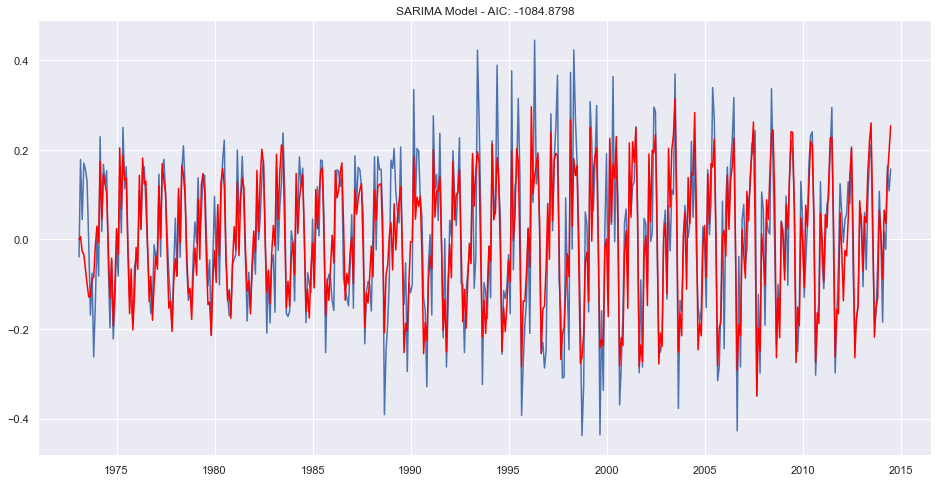

In [69]:
# Create a SARIMA Model to fit to Natural Gas
from statsmodels.tsa.statespace.sarimax import SARIMAX
model_SARIMA = SARIMAX(df_shift, order=(1,0,1), seasonal_order=(1,0,1,12))
results_SARIMA = model_SARIMA.fit()
predictions_SARIMA = results_SARIMA.predict()

#Plotting the original vs predicted series
plt.figure(figsize=(16,8))
plt.plot(df_shift)
plt.plot(results_SARIMA.fittedvalues, color='red')
plt.title('SARIMA Model - AIC: %.4f'% results_SARIMA.aic)
plt.show()

#mean_squared_error(results_SARIMA.fittedvalues,df_shift['Natural Gas']

In [70]:
# Printing the fitted values
predictions_SARIMA=pd.Series(results_SARIMA.fittedvalues)
predictions_SARIMA

Date
1973-02-01    0.000000
1973-03-01    0.006304
1973-04-01   -0.027281
1973-05-01   -0.033328
1973-06-01   -0.067688
                ...   
2014-03-01    0.065163
2014-04-01    0.035529
2014-05-01    0.141396
2014-06-01    0.194896
2014-07-01    0.253685
Length: 498, dtype: float64

In [71]:
#First step - doing cumulative sum
predictions_cumsum_SARIMA = predictions_SARIMA.cumsum()
predictions_cumsum_SARIMA

Date
1973-02-01    0.000000
1973-03-01    0.006304
1973-04-01   -0.020977
1973-05-01   -0.054305
1973-06-01   -0.121993
                ...   
2014-03-01   -1.394299
2014-04-01   -1.358770
2014-05-01   -1.217374
2014-06-01   -1.022478
2014-07-01   -0.768793
Length: 498, dtype: float64

In [72]:
#Second step - Adding the first value of the log series to the cumulative sum values
predictions_log_SARIMA = pd.Series(df_log['Natural Gas'].iloc[0], index=df_log.index)
predictions_log_SARIMA = predictions_log_SARIMA.add(predictions_cumsum_SARIMA, fill_value=0)
predictions_log_SARIMA

Date
1973-01-01    2.499385
1973-02-01    2.499385
1973-03-01    2.505688
1973-04-01    2.478408
1973-05-01    2.445080
                ...   
2014-03-01    1.105086
2014-04-01    1.140615
2014-05-01    1.282011
2014-06-01    1.476907
2014-07-01    1.730592
Length: 499, dtype: float64

In [73]:
#Third step - applying exponential transformation
predictions_SARIMA = np.exp(predictions_log_SARIMA)
predictions_SARIMA

Date
1973-01-01    12.175000
1973-02-01    12.175000
1973-03-01    12.251989
1973-04-01    11.922265
1973-05-01    11.531468
                ...    
2014-03-01     3.019483
2014-04-01     3.128692
2014-05-01     3.603879
2014-06-01     4.379377
2014-07-01     5.643993
Length: 499, dtype: float64

In [74]:
#Forecasting the values for next 24 months
forecasted_SARIMA = results_SARIMA.forecast(steps=24) # here steps represent the number of months
forecasted_SARIMA

2014-08-01    0.052458
2014-09-01   -0.203640
2014-10-01   -0.144521
2014-11-01   -0.107941
2014-12-01    0.092363
2015-01-01    0.026285
2015-02-01   -0.098942
2015-03-01    0.040993
2015-04-01    0.003452
2015-05-01    0.121322
2015-06-01    0.160368
2015-07-01    0.202255
2015-08-01    0.014833
2015-09-01   -0.226592
2015-10-01   -0.160057
2015-11-01   -0.118396
2015-12-01    0.083436
2016-01-01    0.020617
2016-02-01   -0.101514
2016-03-01    0.038057
2016-04-01    0.001725
2016-05-01    0.118842
2016-06-01    0.157827
2016-07-01    0.199504
Freq: MS, Name: predicted_mean, dtype: float64

In [75]:
forecasted_cumsum_SARIMA = forecasted_SARIMA.cumsum()
forecasted_cumsum_SARIMA

2014-08-01    0.052458
2014-09-01   -0.151182
2014-10-01   -0.295703
2014-11-01   -0.403644
2014-12-01   -0.311281
2015-01-01   -0.284997
2015-02-01   -0.383939
2015-03-01   -0.342946
2015-04-01   -0.339494
2015-05-01   -0.218172
2015-06-01   -0.057804
2015-07-01    0.144450
2015-08-01    0.159283
2015-09-01   -0.067309
2015-10-01   -0.227367
2015-11-01   -0.345763
2015-12-01   -0.262327
2016-01-01   -0.241709
2016-02-01   -0.343223
2016-03-01   -0.305166
2016-04-01   -0.303441
2016-05-01   -0.184600
2016-06-01   -0.026773
2016-07-01    0.172732
Freq: MS, Name: predicted_mean, dtype: float64

In [76]:
#Making a new dataframe to get the the indices from 2020-2021
index = pd.date_range('2014-08-01','2016-07-01' , freq='1MS')
df1_SARIMA = pd.DataFrame()
df1_SARIMA['cumsum'] = forecasted_cumsum_SARIMA
df1_SARIMA.index = index
df1_SARIMA

,cumsum
2014-08-01,0.052458
2014-09-01,-0.151182
2014-10-01,-0.295703
2014-11-01,-0.403644
2014-12-01,-0.311281
2015-01-01,-0.284997
2015-02-01,-0.383939
2015-03-01,-0.342946
2015-04-01,-0.339494
2015-05-01,-0.218172


In [77]:
#Adding last value of the log of the training data
df1_SARIMA['Forecasted'] = df1_SARIMA['cumsum'] + float(df_log.loc['2014-07-01'])
df1_SARIMA

,cumsum,Forecasted
2014-08-01,0.052458,3.878945
2014-09-01,-0.151182,3.675305
2014-10-01,-0.295703,3.530784
2014-11-01,-0.403644,3.422843
2014-12-01,-0.311281,3.515206
2015-01-01,-0.284997,3.541490
2015-02-01,-0.383939,3.442548
2015-03-01,-0.342946,3.483541
2015-04-01,-0.339494,3.486993
2015-05-01,-0.218172,3.608315


In [78]:
#Applying exponential transformation to the forecasted log values
forecasted_SARIMA = np.exp(df1_SARIMA['Forecasted'])
forecasted_SARIMA

2014-08-01    48.373162
2014-09-01    39.460703
2014-10-01    34.150734
2014-11-01    30.656447
2014-12-01    33.622843
2015-01-01    34.518327
2015-02-01    31.266521
2015-03-01    32.574857
2015-04-01    32.687513
2015-05-01    36.903812
2015-06-01    43.322961
2015-07-01    53.034219
2015-08-01    53.826712
2015-09-01    42.913129
2015-10-01    36.566054
2015-11-01    32.483231
2015-12-01    35.309794
2016-01-01    36.045337
2016-02-01    32.565844
2016-03-01    33.829091
2016-04-01    33.887482
2016-05-01    38.163793
2016-06-01    44.688419
2016-07-01    54.555503
Freq: MS, Name: Forecasted, dtype: float64

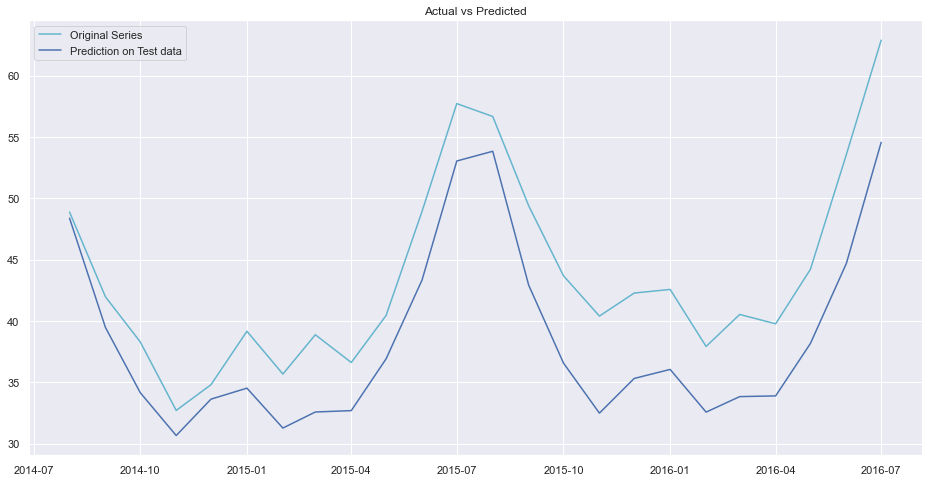

In [79]:
#Plotting the original vs predicted series
plt.figure(figsize=(16,8))
plt.plot(df_NG.loc['2014-08-01':], color = 'c', label = 'Original Series')
# plt.plot(predictions_SARIMA, color = 'r', label = 'Prediction on Train data')
plt.plot(forecasted_SARIMA, label = 'Prediction on Test data', color='b')
plt.title('Actual vs Predicted')
plt.legend()
plt.show()

In [80]:
from sklearn.metrics import mean_squared_error
error = mean_squared_error(forecasted_SARIMA, df_test, squared = False)
error

5.543629456613582

### Observations

The forecast on the test set resulted in an RMSE = 5.54, which can be considered small and evidence that good fitting results were obtained. The model was able to take into account the seasonality in the data like the local maximum that occurs around July. One downside of the model is it underestimated the CO2 emmissions. This can be problem since, in terms of business context, it'll be better to overestimate than underestimate.

Overestimation may be better because of deadlines according to the Paris Agreement. By underestimating the emissions, it may bring a false sense of security for a government worker who's putting together an accurate report on the U.S.'s progress to fight climate change. If anything, the government worker would want an overestimation since it can spark quicker policy actions and implementations.